# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'NeuralNetwork'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/picts'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = True
development_events = 100

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 7.79628753662e-05 seconds
Time to read data file: 6.96557712555 seconds


Using TensorFlow backend.


Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events


In [30]:
# Train Function
from Functions import TrainParameters as trnparams
from sklearn import preprocessing


from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.utils import np_utils

def NeuralTrainFunction(data=None, trgt=None, 
                        ifold=0, n_folds=2, n_neurons=10, 
                        trn_params=None, save_path='', dev=False):
    
    
    # turn targets in sparse mode
    trgt_sparse = np_utils.to_categorical(trgt.astype(int))
    
    # load or create cross validation ids
    #n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=save_path,n_folds=n_folds,trgt=trgt,dev=dev)


    n_folds = len(CVO)
    n_inits = trn_params.params['n_inits']

    params_str = trn_params.get_params_str()
    
    analysis_str = 'NeuralNetwork'
    model_prefix_str = 'RawData'

    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   n_neurons)

    
    if not development_flag:
        file_name = '%s_%i_fold_model.h5'%(model_str,ifold)
        if os.path.exists(file_name):
            #print 'File %s exists'%(file_name)
            return 0
    else:
        file_name = '%s_%i_fold_model_dev.h5'%(model_str,ifold)
        if os.path.exists(file_name):
            #print 'File %s exists'%(file_name)
            return 0

    #print "Fold: %i"%(ifold+1)
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])

    norm_data = scaler.transform(data)

    best_init = 0
    best_loss = 999

    classifier = []
    trn_desc = {}

    for i_init in range(n_inits):
        print 'Neuron: %i - Fold %i of %i Folds -  Init %i of %i Inits'%(n_neurons, 
                                                                         ifold+1, 
                                                                         n_folds, 
                                                                         i_init+1,
                                                                         n_inits)
        model = Sequential()
        model.add(Dense(n_neurons, input_dim=data.shape[1], init="uniform"))
        model.add(Activation(trn_params.params['hidden_activation']))
        model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
        model.add(Activation(trn_params.params['output_activation']))

        sgd = SGD(lr=trn_params.params['learning_rate'], 
                  decay=trn_params.params['learning_decay'], 
                  momentum=trn_params.params['momentum'], 
                  nesterov=trn_params.params['nesterov'])
        model.compile(loss='mean_squared_error', 
                      optimizer=sgd,
                      metrics=['accuracy'])
        # Train model
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=trn_params.params['patience'],
                                                verbose=trn_params.params['train_verbose'], 
                                                mode='auto')

        init_trn_desc = model.fit(norm_data[train_id], trgt_sparse[train_id], 
                                  nb_epoch=trn_params.params['n_epochs'], 
                                  batch_size=trn_params.params['batch_size'],
                                  callbacks=[earlyStopping], 
                                  verbose=trn_params.params['verbose'],
                                  validation_data=(norm_data[test_id],
                                                   trgt_sparse[test_id]),
                                  shuffle=True)
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifier = model
            trn_desc['epochs'] = init_trn_desc.epoch
            trn_desc['acc'] = init_trn_desc.history['acc']
            trn_desc['loss'] = init_trn_desc.history['loss']
            trn_desc['val_loss'] = init_trn_desc.history['val_loss']
            trn_desc['val_acc'] = init_trn_desc.history['val_acc']

    # save model
    if not development_flag:        
        file_name = '%s_%i_fold_model.h5'%(model_str,ifold)
        classifier.save(file_name)
        file_name = '%s_%i_fold_trn_desc.jbl'%(model_str,ifold)
        joblib.dump([trn_desc],file_name,compress=9)
    else:
        file_name = '%s_%i_fold_model_dev.h5'%(model_str,ifold)
        classifier.save(file_name)
        file_name = '%s_%i_fold_trn_desc_dev.jbl'%(model_str,ifold)
        joblib.dump([trn_desc],file_name,compress=9)


In [8]:
# Train example

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)


n_folds = 2
CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

for ifold in range(len(CVO)):
    for ineuron in range(1,10,1):
        NeuralTrainFunction(data=all_data, trgt=all_trgt, ifold=ifold, n_folds=n_folds, 
                            n_neurons=ineuron, trn_params=trn_params, 
                            save_path=results_path,dev=True)


File /Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/2_folds_cross_validation_dev.jbl exists
File /Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/2_folds_cross_validation_dev.jbl exists
File /Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_1_inits_mapstd_norm_10_epochs_4_batch_size_tanh_activation_1_neurons_fold_0_model_dev.h5 exists
File /Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/2_folds_cross_validation_dev.jbl exists
File /Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_1_inits_mapstd_norm_10_epochs_4_batch_size_tanh_activation_2_neurons_fold_0_model_dev.h5 exists
File /Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/2_folds_cross_validation_dev.jbl exists
File /Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_fold

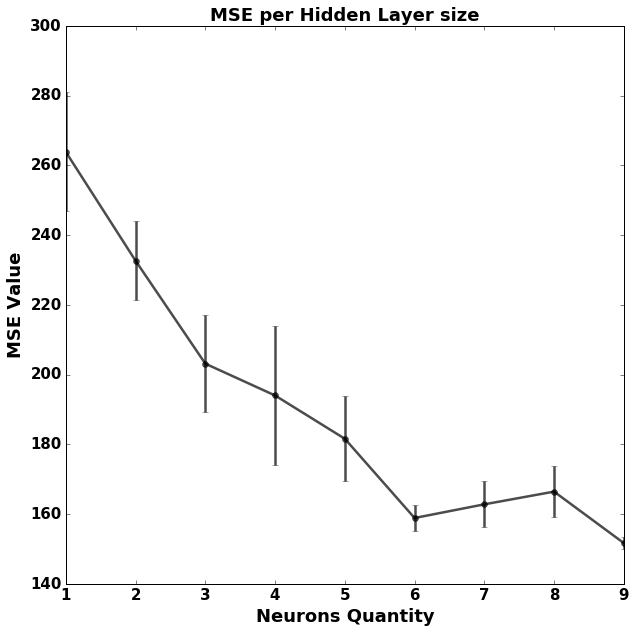

In [19]:
# analysis example - neuron variation

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.utils import np_utils
from keras.models import load_model

from Functions import TrainParameters as trnparams


# generate analysis data
save_path=results_path

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

analysis_file_name='%s/%s/%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
    
    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = range(1,10,1)

    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data)

        for ineuron,neuron_value in enumerate(neurons_mat):       
            NeuralTrainFunction(data=all_data, trgt=all_trgt, ifold=ifold, n_folds=n_folds, 
                                n_neurons=neuron_value, trn_params=trn_params, 
                                save_path=results_path,dev=True)

            # turn targets in sparse mode
            trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))


            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,
                                                       neuron_value)

            model = Sequential()
            model.add(Dense(neuron_value, input_dim=data.shape[1], init="uniform"))
            model.add(Activation(trn_params.params['hidden_activation']))
            model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
            model.add(Activation(trn_params.params['output_activation']))

            if not development_flag:        
                file_name = '%s_%i_fold_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_%i_fold_model_dev.h5'%(model_str,ifold)
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = np.mean(np.sum((trgt_sparse-output)**2))
            mse_mat[ifold,ineuron] = mse
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)
ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold')



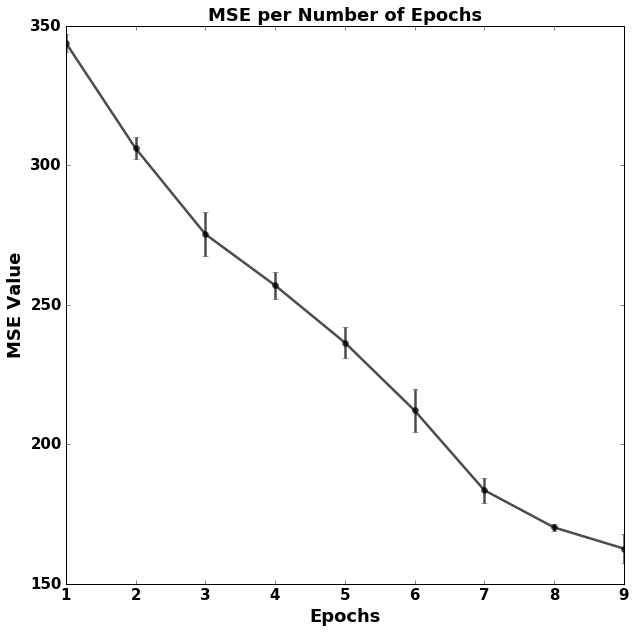

In [33]:
# analysis example - number epochs

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.utils import np_utils
from keras.models import load_model

from Functions import TrainParameters as trnparams


# generate analysis data
save_path=results_path

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

analysis_file_name='%s/%s/%s_epochs_sweep.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(analysis_file_name):
    
    epochs_mat = range(1,10,1)
    mse_mat = np.zeros([n_folds,len(epochs_mat)])
    
    for iepochs,epochs_value in enumerate(epochs_mat):       
        print "Number of Epochs:", epochs_value
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1, n_epochs=epochs_value)
    
        params_str = trn_params.get_params_str()
        print "params_str: ",params_str
        n_folds = 2
        CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)


        for ifold in range(len(CVO)):
            train_id, test_id = CVO[ifold]

            # normalize data based in train set
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

            norm_data = scaler.transform(all_data)
            
            neurons =10
            NeuralTrainFunction(data=all_data, trgt=all_trgt, ifold=ifold, n_folds=n_folds, 
                                n_neurons=neurons, trn_params=trn_params, 
                                save_path=results_path,dev=True)

            # turn targets in sparse mode
            trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))


            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                           model_prefix_str,
                                                           n_folds,
                                                           params_str,
                                                           neurons)

            model = Sequential()
            model.add(Dense(neurons, input_dim=data.shape[1], init="uniform"))
            model.add(Activation(trn_params.params['hidden_activation']))
            model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
            model.add(Activation(trn_params.params['output_activation']))

            if not development_flag:        
                file_name = '%s_%i_fold_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_%i_fold_model_dev.h5'%(model_str,ifold)
                
            print 'Model name: %s'%(file_name)
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = np.mean(np.sum((trgt_sparse-output)**2))
            mse_mat[ifold,iepochs] = mse
    joblib.dump([mse_mat,epochs_mat],analysis_file_name,compress=9)
else:
    [mse_mat,epochs_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(epochs_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)
ax.set_title('MSE per Number of Epochs',fontsize=18,weight='bold')
ax.set_xlabel('Epochs',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold')

[[   0.            0.            0.            0.            0.            0.
     0.            0.          167.94212036]
 [   0.            0.            0.            0.            0.            0.
     0.            0.          157.30902446]]
